In [1]:
import pandas as pd
from itertools import chain

In [2]:
filename = "percent-dev-share.csv"

In [3]:
def get_values(path):
    df = pd.read_csv(path, skiprows=12)
#     df = df.drop(columns="[all run data]")
    df = df.drop(columns="[initial & final values]")
    
    df.columns = range(1, len(df.columns)+1)
    df = df.mean()
    return df

values = get_values(filename)
values

1      777.203271
2      777.203271
3      777.203271
4      777.203271
5      777.203271
          ...    
571    280.362141
572    288.996201
573    283.302432
574    312.189502
575    331.795403
Length: 575, dtype: float64

In [4]:
import csv


def get_params(path):
    df = pd.DataFrame()
    with open(path) as csvfile:
        spamreader = csv.reader(csvfile)
        for i, row in enumerate(spamreader):
            if i < 6:
                continue
            if i >= 11:
                break
#             print(row)
            col = pd.Series(row[1:])
            try:
                col = pd.to_numeric(col)
            except ValueError:
                pass
            df[row[0]] = col.convert_dtypes()
    return df

params = get_params(filename)
params

,[run number],oak-percentage,rain-deviation,oak-tolerance-share,[steps]
0,1,0,0.5,0,2000
1,2,0,0.5,25,2000
2,3,0,0.5,50,2000
3,4,0,0.5,75,2000
4,5,0,0.5,100,2000
...,...,...,...,...,...
570,571,100,1.5,0,2000
571,572,100,1.5,25,2000
572,573,100,1.5,50,2000
573,574,100,1.5,75,2000


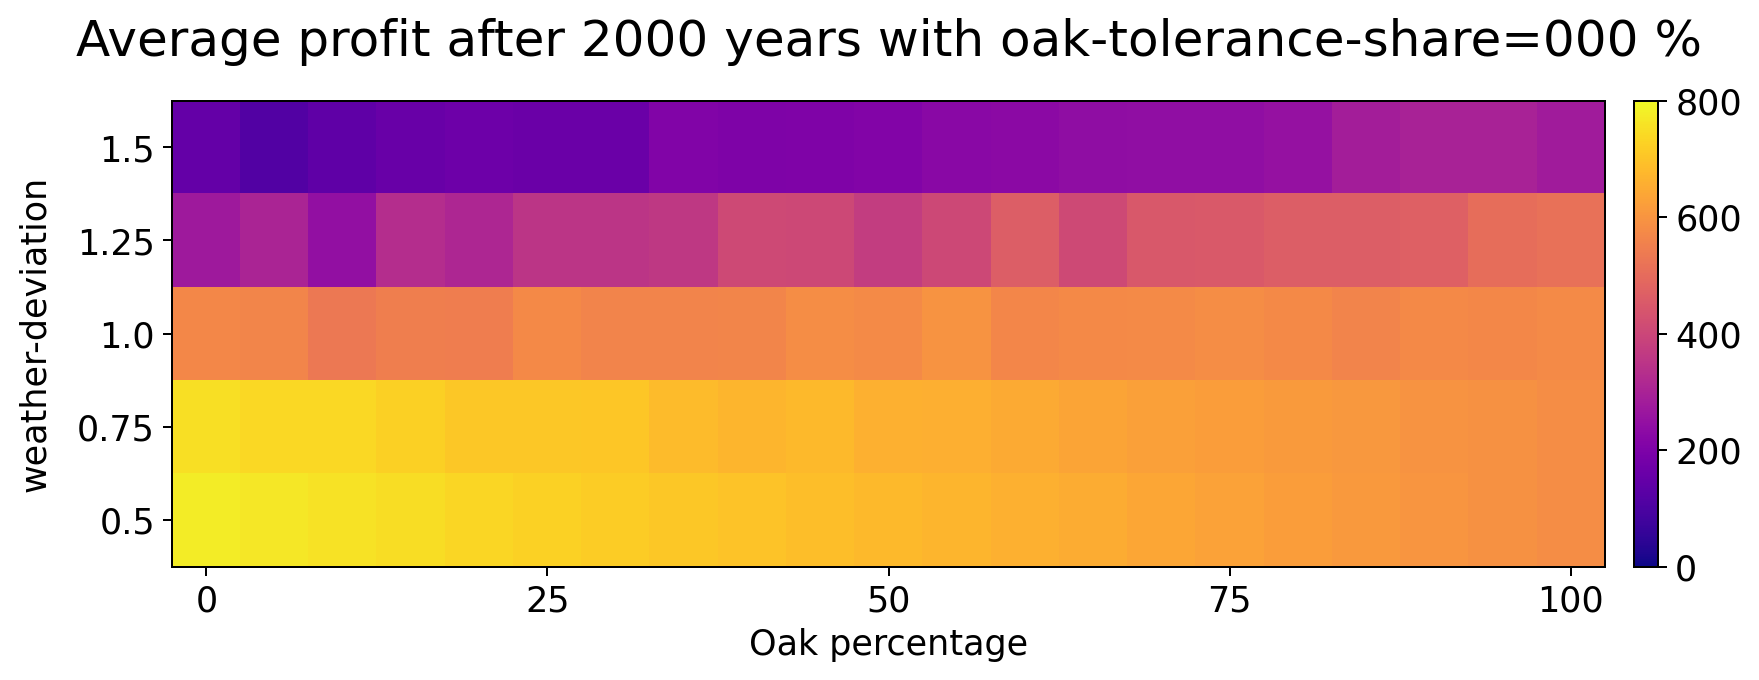

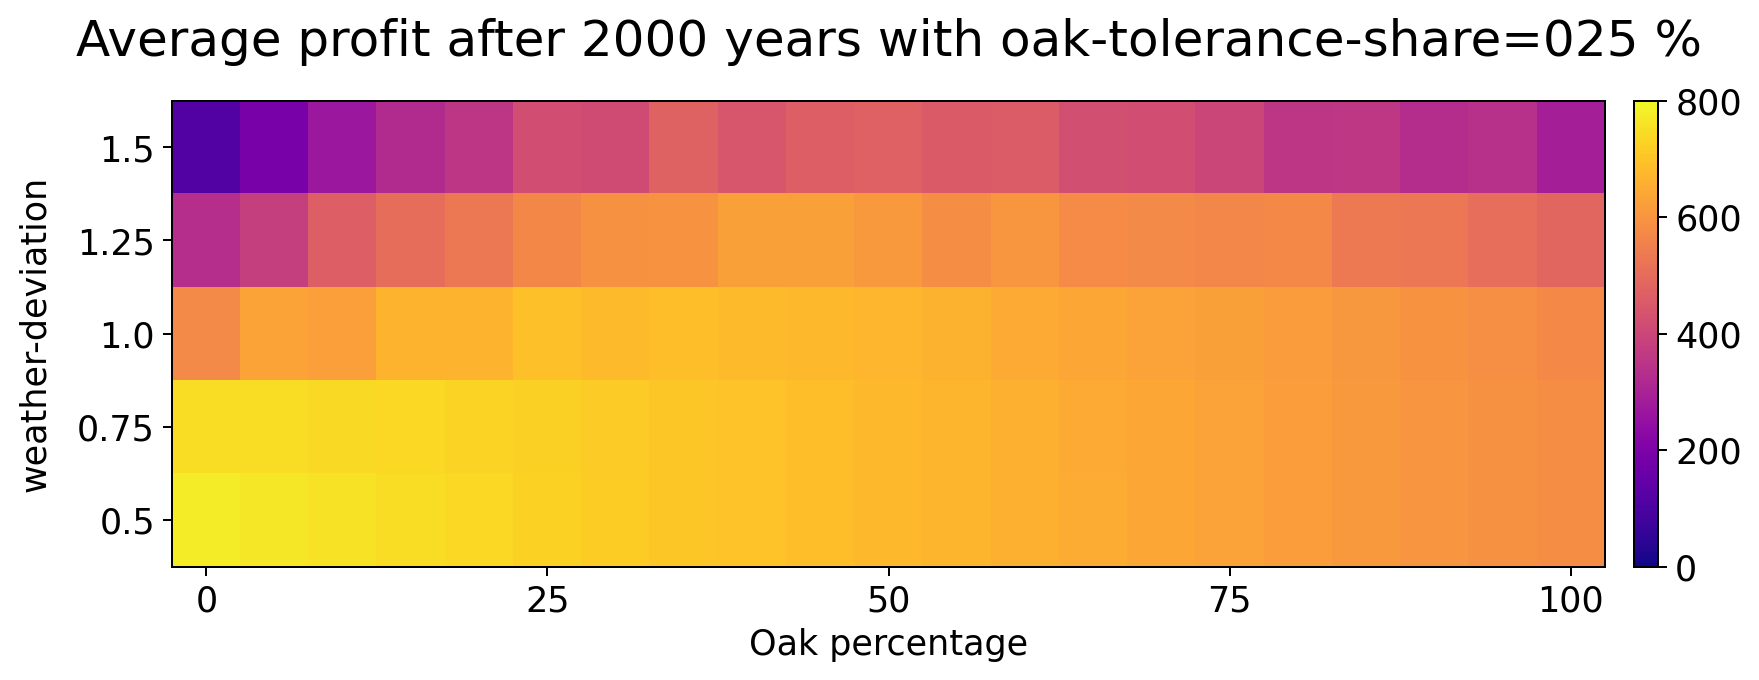

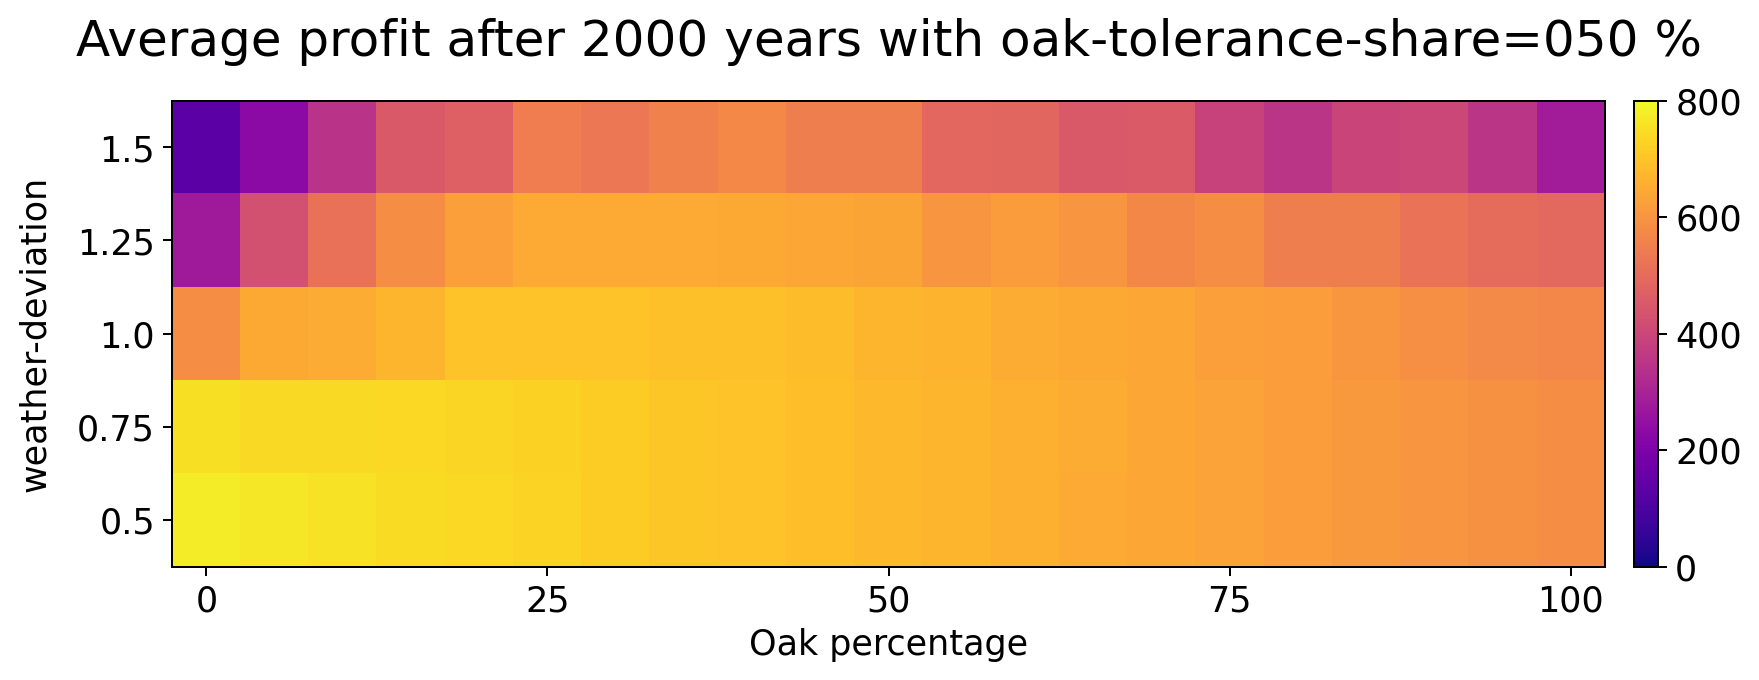

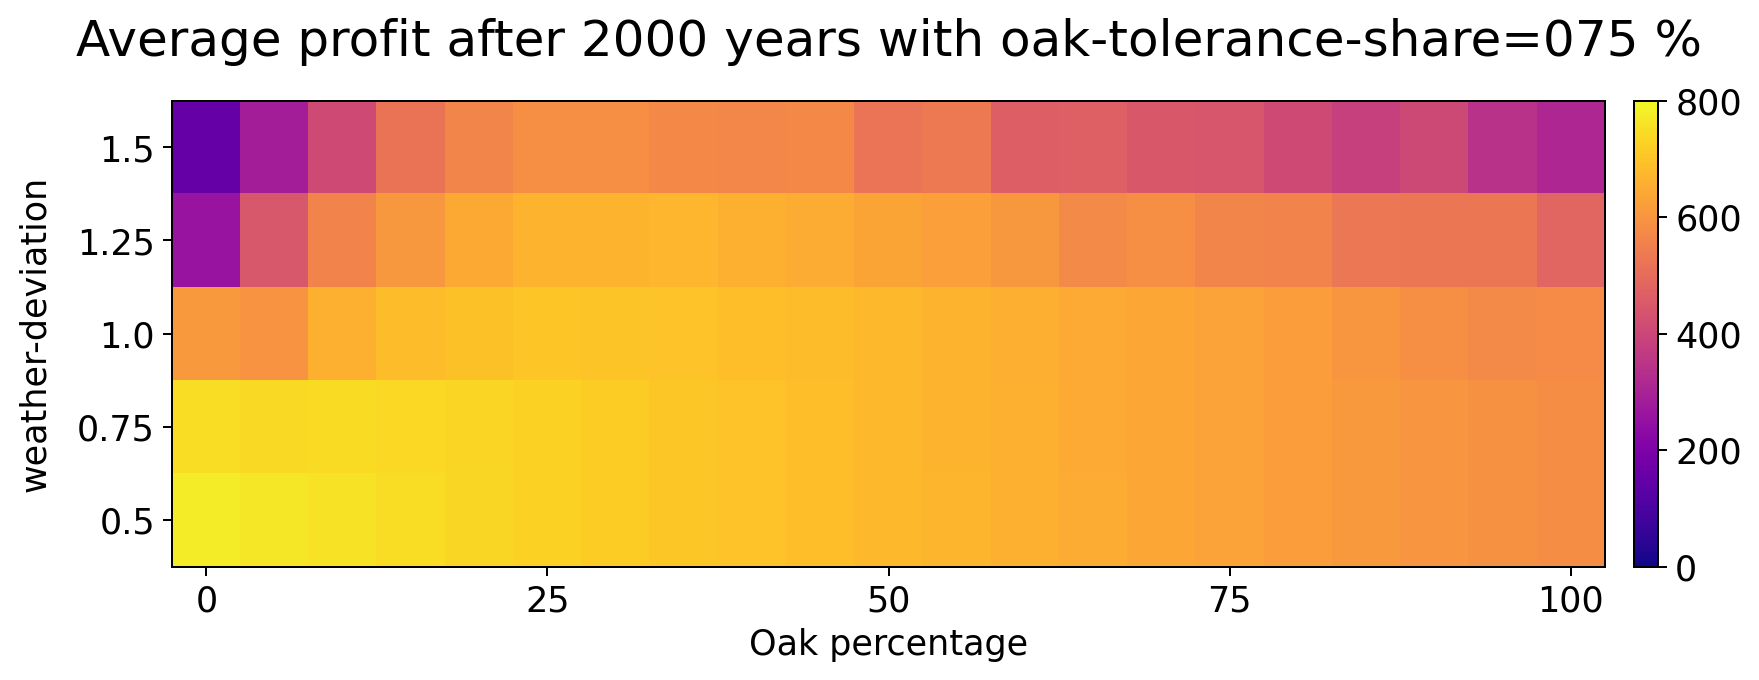

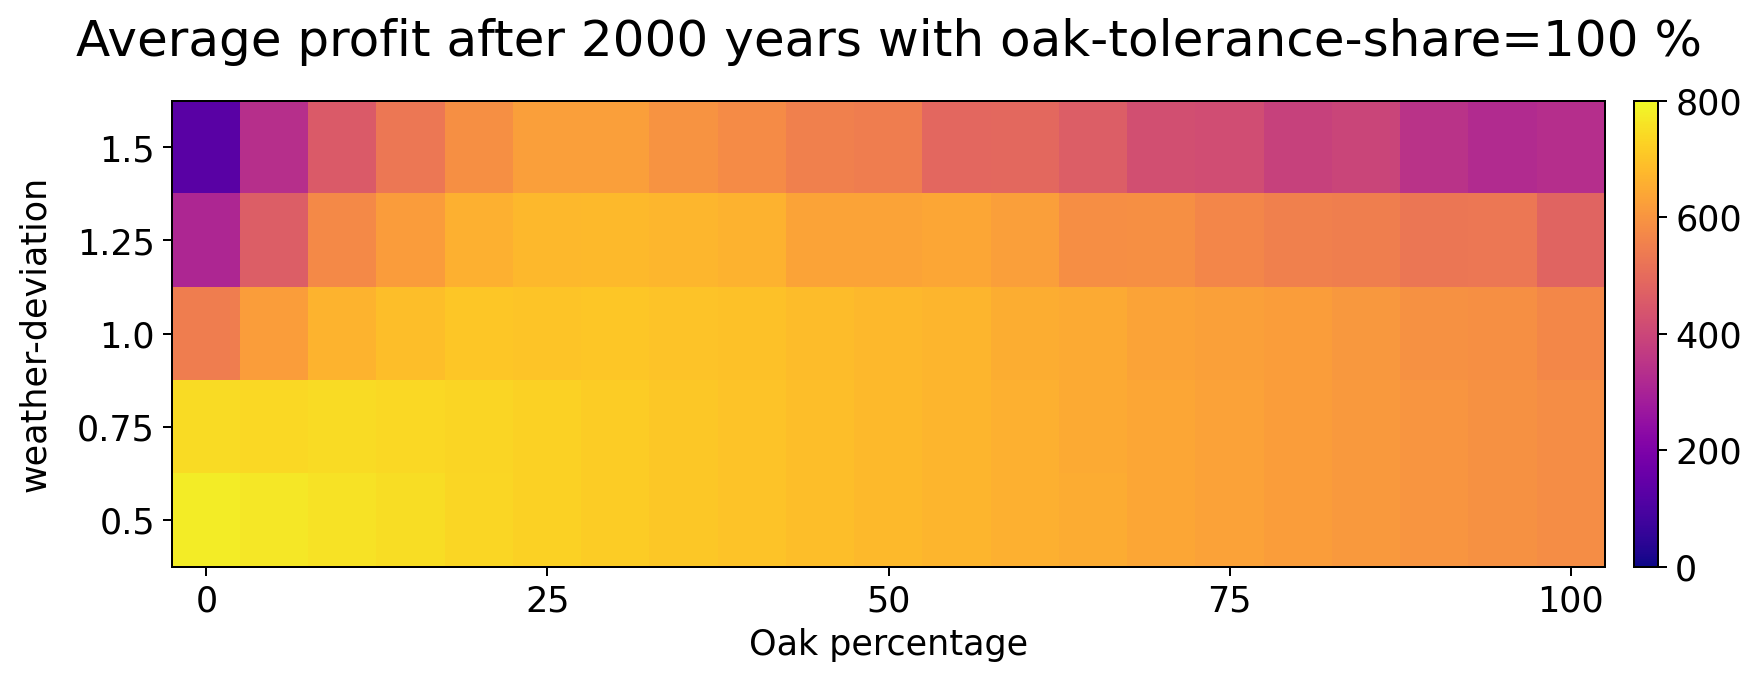

In [44]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rc('font', size=14)


def get_index(ser):
    return {x: i for i, x in enumerate(sorted(ser.unique()))}


def to_matrix(values, params, valindex, xcol, ycol):
    xindex = get_index(params[xcol])
    yindex = get_index(params[ycol])
    
    mats = {}
    for evap_mul, rest_params in params.groupby("oak-tolerance-share"):
#         print(evap_mul)
        mat = np.zeros((len(yindex), len(xindex)))
        for param in rest_params.iloc:
            val = values.loc[param[valindex]]
            x = xindex[param[xcol]]
            y = yindex[param[ycol]]
            mat[y, x] = val
        mats[evap_mul] = mat
    
    return mats, xindex, yindex

def to_imgmat(mat):
    mat -= mat.min()
    mat *= 256/mat.max()
    mat = mat.astype(np.uint8)
    return mat

def to_img(mat):
    im = Image.fromarray(np.uint8(cm.gist_earth(myarray)*255))

    
def make_matrixes():
    mats, xindex, yindex = to_matrix(values, params, "[run number]", "oak-percentage", "rain-deviation")
    for evap_mul, mat in mats.items():
        title = f"Average profit after 2000 years with oak-tolerance-share={evap_mul:03d} %"
        make_matrix(mat, title, xindex, yindex)
#     mat = to_imgmat(mat)
# img = to_img(mat)

gax = None

def mapminmax(x, xmin, xmax, xlen, doint=True):
    val = xmin + x * (xmax-xmin) / (xlen - 1)
    if doint:
        val = int(val)
    return val

def reverse_index(index):
    return {value: key for key, value in index.items()}
    
def mapindex(x, index):
    if x not in index:
        return "?"
    return index[x]

def make_matrix(mat, title, xindex, yindex):
    fig = plt.figure(figsize=(10, 4), dpi=180)
    ax = fig.add_subplot(111)
    cax = ax.matshow(mat, cmap="plasma", origin="lower", aspect="auto", vmax=800, vmin=0)
    
#     print(yindex)
#     print(ax.yaxis.get_ticklocs())
#     ylen, xlen = mat.shape
#     xmin, xmax = 0, 100
#     ymin, ymax = 0.5, 1.5
    
    rxindex = reverse_index(xindex)
    ryindex = reverse_index(yindex)

    
    ax.xaxis.set_major_locator(ticker.FixedLocator(ax.xaxis.get_ticklocs()))
    ax.xaxis.set_ticklabels(mapindex(x, rxindex) for x in ax.xaxis.get_ticklocs())
#     ax.xaxis.set_ticklabels(mapminmax(x, xmin, xmax, xlen) for x in ax.xaxis.get_ticklocs())
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)

    
    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.yaxis.get_ticklocs()))
    ax.yaxis.set_ticklabels(mapindex(y, ryindex) for y in ax.yaxis.get_ticklocs())
#     ax.yaxis.set_ticklabels(mapminmax(y, ymin, ymax, ylen, False) for y in ax.yaxis.get_ticklocs())


    plt.colorbar(cax, fraction=0.0160, pad=0.02)
    
    ax.axes.set_title(title, pad=18, fontsize=20)
    ax.axes.set_ylabel("weather-deviation", labelpad=10)
    ax.axes.set_xlabel("Oak percentage")
#     ax.title.set_position([.5, -1.2])
    plt.tight_layout()
#     plt.savefig(f"plots/{title}.png")
    

make_matrixes()

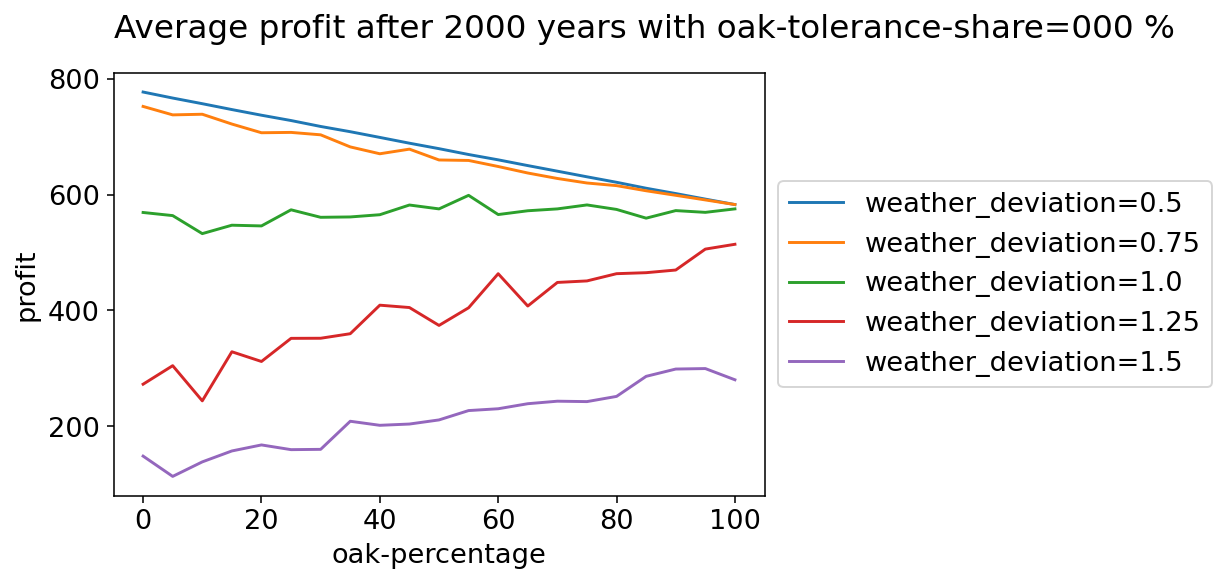

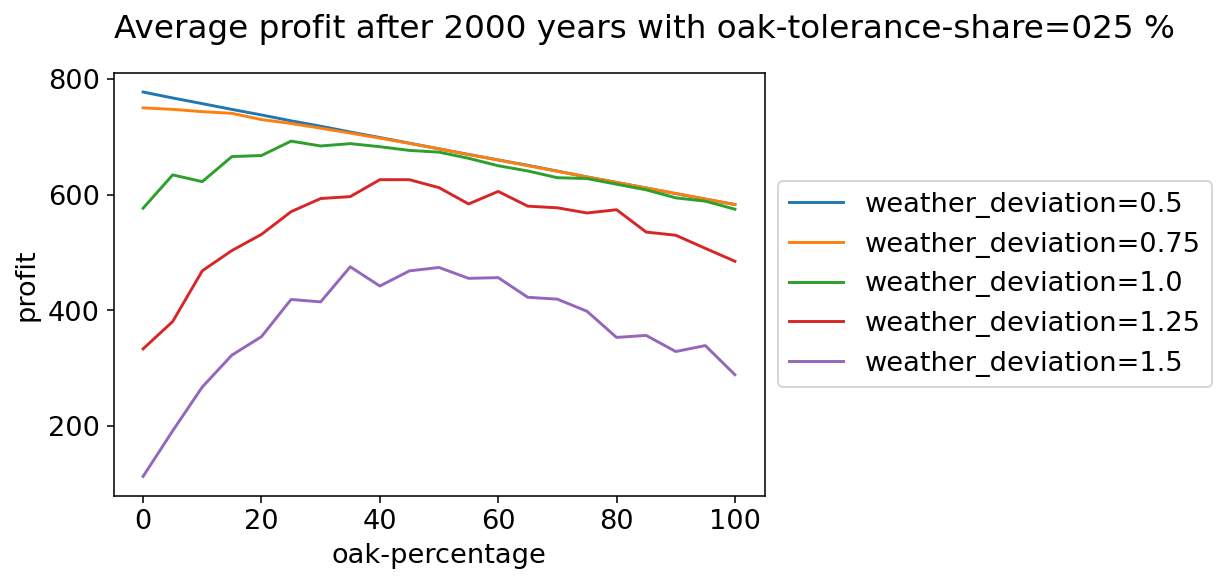

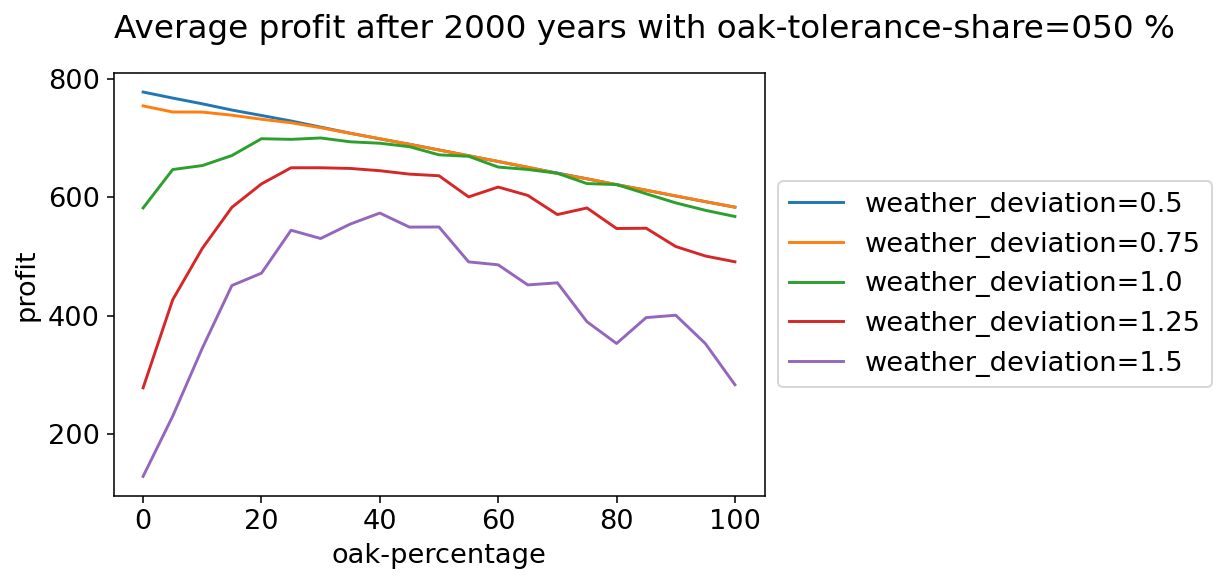

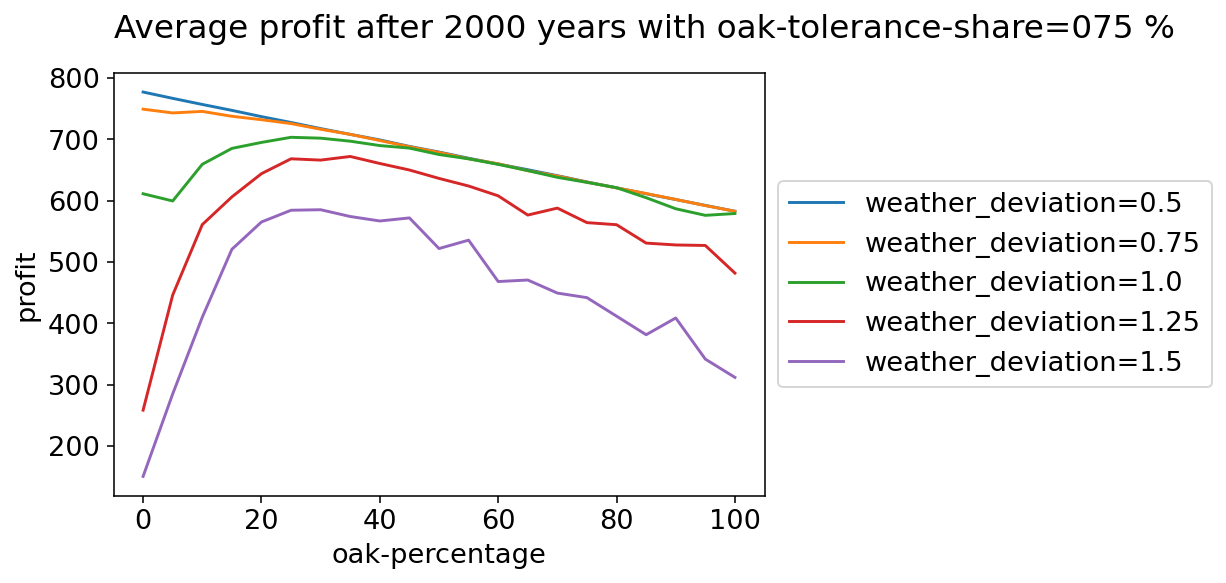

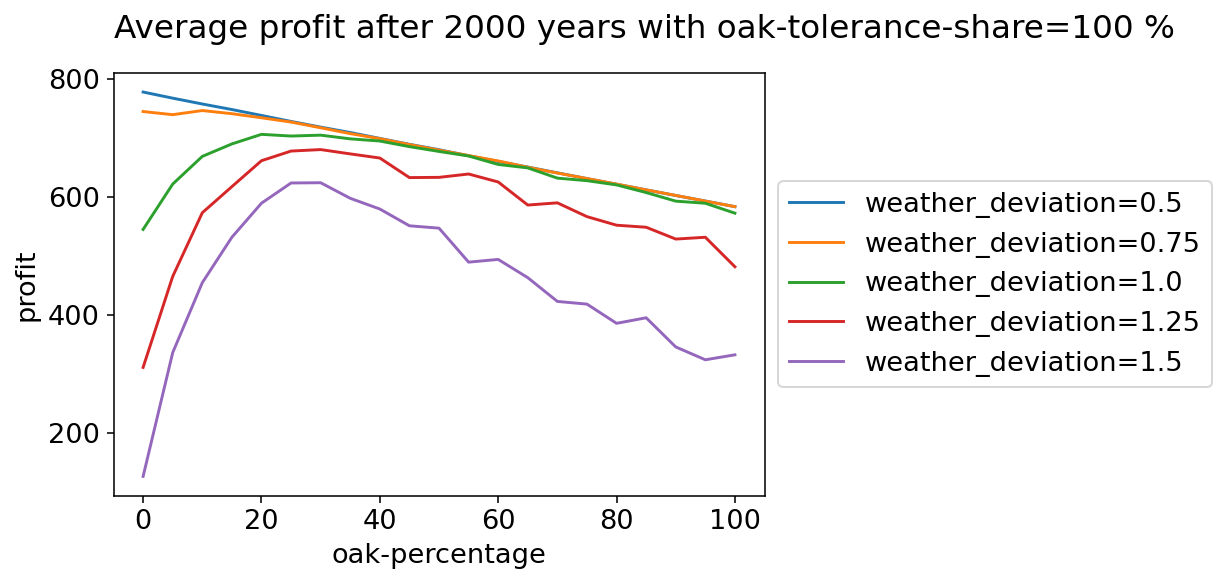

In [60]:
def make_2dMats():
    mats, xindex, yindex = to_matrix(values, params, "[run number]", "oak-percentage", "rain-deviation")
    for par, mat in mats.items():
#         if par != 25:
#             continue
        make_2dMat(mat, par, xindex, yindex)
        
def make_2dMat(mat, par, xindex, yindex):
    df = pd.DataFrame(mat).T
    rxindex = reverse_index(xindex)
    ryindex = reverse_index(yindex)
    df.columns = [f"weather_deviation={ryindex[c]}" for c in df.columns]
    df.index = xindex.keys()
    
    fig = plt.figure(dpi=140)
    ax = plt.gca()    
    df.plot(xlabel="oak-percentage", ylabel="profit", ax=ax)
    
    title = f"Average profit after 2000 years with oak-tolerance-share={par:03d} %"
    ax.axes.set_title(title, pad=18, loc="left")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.savefig(f"plots/2d_{par:03d}.png", bbox_inches = 'tight')
#     display(df)
    
make_2dMats()